In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# -----------------------------
# 1) 데이터 불러오기
# -----------------------------

raw = pd.read_csv(
    '/content/drive/MyDrive/ml-programming-lab/week11/WISDM.csv',
    header=None
)

print("원본 CSV 크기:", raw.shape)
print(raw.head())

# 컬럼 개수에 따라 이름 지정 (index 포함 여부에 대비)
if raw.shape[1] == 7:
    raw.columns = ["row_id", "user_id", "activity", "timestamp",
                   "x_axis", "y_axis", "z_axis"]
    df = raw.drop(columns=["row_id"])
elif raw.shape[1] == 6:
    raw.columns = ["user_id", "activity", "timestamp",
                   "x_axis", "y_axis", "z_axis"]
    df = raw.copy()
else:
    raise ValueError("예상과 다른 열 개수입니다. CSV 구조를 먼저 확인해 주세요.")

print("\n[컬럼 정리 후 데이터]")
print(df.head())
print("현재 컬럼:", df.columns.tolist())

원본 CSV 크기: (1048575, 7)
   0   1        2             3         4          5         6
0  0  33  Jogging  4.910600e+13 -0.694638  12.680544  0.503953
1  1  33  Jogging  4.910610e+13  5.012288  11.264028  0.953424
2  2  33  Jogging  4.910610e+13  4.903325  10.882658 -0.081722
3  3  33  Jogging  4.910620e+13 -0.612916  18.496431  3.023717
4  4  33  Jogging  4.910630e+13 -1.184970  12.108489  7.205164

[컬럼 정리 후 데이터]
   user_id activity     timestamp    x_axis     y_axis    z_axis
0       33  Jogging  4.910600e+13 -0.694638  12.680544  0.503953
1       33  Jogging  4.910610e+13  5.012288  11.264028  0.953424
2       33  Jogging  4.910610e+13  4.903325  10.882658 -0.081722
3       33  Jogging  4.910620e+13 -0.612916  18.496431  3.023717
4       33  Jogging  4.910630e+13 -1.184970  12.108489  7.205164
현재 컬럼: ['user_id', 'activity', 'timestamp', 'x_axis', 'y_axis', 'z_axis']


In [ ]:
# -----------------------------
# 2) 결측/이상 값 간단 정리
# -----------------------------

# z_axis에 ';' 같은 문자가 섞여 있을 가능성 대비
df["z_axis"] = df["z_axis"].astype(str).str.replace(";", "")
df["z_axis"] = pd.to_numeric(df["z_axis"], errors='coerce')

# 결측치 제거
df.dropna(axis=0, how='any', inplace=True)
df.reset_index(drop=True, inplace=True)

print("\n[결측 제거 후 데이터 크기]:", df.shape)


[결측 제거 후 데이터 크기]: (1048575, 6)


In [ ]:
# -----------------------------
# 3) activity 분포 확인 (value_counts)
# -----------------------------

df['activity'] = df['activity'].astype(str).str.strip()

print("\n[activity 분포 (value_counts)]")
print(df['activity'].value_counts())


[activity 분포 (value_counts)]
activity
Walking       406775
Jogging       325975
Upstairs      118589
Downstairs     97813
Sitting        54876
Standing       44547
Name: count, dtype: int64


In [ ]:
# -----------------------------
# 4) 6개 중 2개 선택 + 이진 인코딩
# -----------------------------

target_acts = ['Jogging', 'Sitting']

binary_df = df[df['activity'].isin(target_acts)].copy()

binary_mapping = {'Jogging': 0, 'Sitting': 1}
binary_df['BinaryLabel'] = binary_df['activity'].map(binary_mapping)

print("\n[이진 분류용 activity 분포]")
print(binary_df['activity'].value_counts())
print(binary_df[['user_id', 'activity', 'BinaryLabel']].head())


[이진 분류용 activity 분포]
activity
Jogging    325975
Sitting     54876
Name: count, dtype: int64
   user_id activity  BinaryLabel
0       33  Jogging            0
1       33  Jogging            0
2       33  Jogging            0
3       33  Jogging            0
4       33  Jogging            0


In [ ]:
# -----------------------------
# 5) 전처리 (user_id, timestamp 제거 + 스케일링)
# -----------------------------

# 타임스탬프, 서브젝트(user_id) 드롭
binary_df = binary_df.drop(columns=['user_id', 'timestamp'], errors='ignore')

scale_columns = ["x_axis", "y_axis", "z_axis"]

scaler = RobustScaler()
scaler = scaler.fit(binary_df[scale_columns])
binary_df.loc[:, scale_columns] = scaler.transform(
    binary_df[scale_columns].to_numpy()
)

print("\n[스케일링 후 예시]")
print(binary_df.head())


[스케일링 후 예시]
  activity    x_axis    y_axis    z_axis  BinaryLabel
0  Jogging -0.070024  0.721143  0.023882            0
1  Jogging  0.505271  0.606631  0.076513            0
2  Jogging  0.494287  0.575801 -0.044698            0
3  Jogging -0.061786  1.191304  0.318936            0
4  Jogging -0.119453  0.674898  0.808567            0


In [ ]:
# -----------------------------
# 6) 학습/테스트 데이터 분리
# -----------------------------

#    - 학습 : Normal(Jogging)만 사용
#    - 테스트 : Normal + Abnormal 둘 다 사용
#    - 테스트는 레이블(y_test)은 따로 보관만 하고, 모델에는 X_test만 넣음
normal_df   = binary_df[binary_df['BinaryLabel'] == 0]   # Jogging
abnormal_df = binary_df[binary_df['BinaryLabel'] == 1]   # Sitting

X_train = normal_df[scale_columns].values
X_test  = pd.concat([normal_df, abnormal_df])[scale_columns].values
y_test  = pd.concat([normal_df, abnormal_df])['BinaryLabel'].values

print("\n[학습/테스트 크기]")
print("X_train:", X_train.shape)
print("X_test :", X_test.shape, " y_test:", y_test.shape)


[학습/테스트 크기]
X_train: (325975, 3)
X_test : (380851, 3)  y_test: (380851,)


In [ ]:
# -----------------------------
# 7) Autoencoder 모델 정의
# -----------------------------

input_dim    = X_train.shape[1]   # 3 (x, y, z)
encoding_dim = 4                  # 잠재 차원 (원하면 조절 가능)

input_layer = Input(shape=(input_dim,))
encoded = Dense(8, activation='relu')(input_layer)
encoded = Dense(encoding_dim, activation='relu')(encoded)
decoded = Dense(8, activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

autoencoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 8)              │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 135 (540.00 B)

 Trainable params: 135 (540.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# -----------------------------
# 8) Autoencoder 학습 (정상 데이터만)
# -----------------------------

history = autoencoder.fit(
    X_train, X_train,          # 입력 = 출력
    epochs=50,
    batch_size=256,
    shuffle=True,
    validation_split=0.1,
    verbose=True
)

Epoch 1/50
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.6195 - val_loss: 0.3721
Epoch 2/50
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3116 - val_loss: 0.3710
Epoch 3/50
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3109 - val_loss: 0.3707
Epoch 4/50
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3095 - val_loss: 0.3703
Epoch 5/50
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3081 - val_loss: 0.3702
Epoch 6/50
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3104 - val_loss: 0.3699
Epoch 7/50
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3103 - val_loss: 0.3699
Epoch 8/50
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.3096 - val_loss: 0.3699
Epoch 9/50
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.3099 - val_loss: 0.3698
Epoch 10/50
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3102 - val_loss: 0.3698
Epoch 11/50
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.3090 - val_loss: 0.3698
Epoch 12/50
1147/1147 ━━━━━━━━

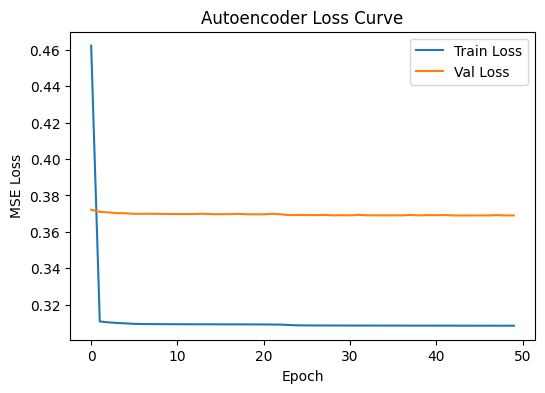

In [ ]:
# -----------------------------
# 9) 학습 손실 곡선 시각화
# -----------------------------

plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Autoencoder Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

In [ ]:
# -----------------------------
# 10) Reconstruction Error 계산
# -----------------------------

# 테스트 입력(X_test)만 모델에 넣음
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)

error_df = pd.DataFrame({
    'reconstruction_error': mse,
    'true_class': y_test
})

print("\n[재구성 오차 통계]")
print(error_df.describe())

11902/11902 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step

[재구성 오차 통계]
       reconstruction_error     true_class
count         380851.000000  380851.000000
mean               0.276225       0.144088
std                0.419007       0.351179
min                0.000002       0.000000
25%                0.025074       0.000000
50%                0.096698       0.000000
75%                0.334367       0.000000
max                3.770683       1.000000


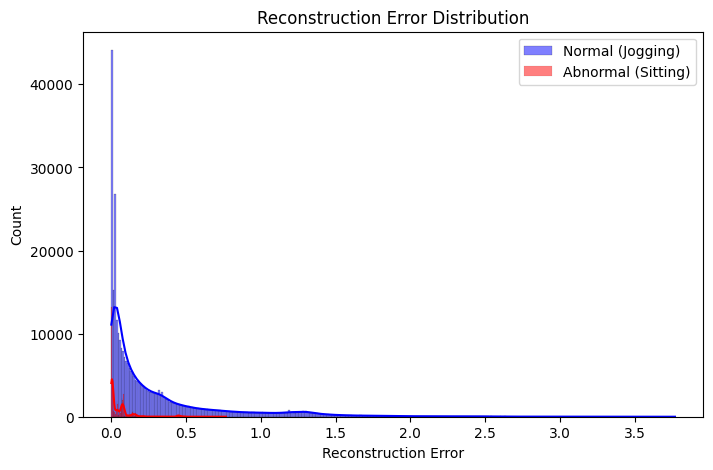

In [ ]:
# -----------------------------
# 11) 정상 / 이상 오차 분포 시각화
# -----------------------------

plt.figure(figsize=(8, 5))
sns.histplot(error_df.reconstruction_error[error_df.true_class == 0],
             label='Normal (Jogging)', color='blue', kde=True)
sns.histplot(error_df.reconstruction_error[error_df.true_class == 1],
             label='Abnormal (Sitting)', color='red', kde=True)
plt.title("Reconstruction Error Distribution")
plt.xlabel("Reconstruction Error")
plt.legend()
plt.show()

In [ ]:
# -----------------------------
# 12) Threshold 설정 & 이상 탐지
# -----------------------------

normal_errors = error_df.reconstruction_error[error_df.true_class == 0]
threshold = np.percentile(normal_errors, 99)

print("\n선택한 Threshold (Normal 99th percentile):", threshold)

y_pred = (error_df.reconstruction_error > threshold).astype(int)


선택한 Threshold (Normal 99th percentile): 1.9896417754538258



Confusion Matrix:
 [[322715   3260]
 [ 54876      0]]

Classification Report:

                   precision    recall  f1-score   support

  Normal(Jogging)       0.85      0.99      0.92    325975
Abnormal(Sitting)       0.00      0.00      0.00     54876

         accuracy                           0.85    380851
        macro avg       0.43      0.49      0.46    380851
     weighted avg       0.73      0.85      0.79    380851



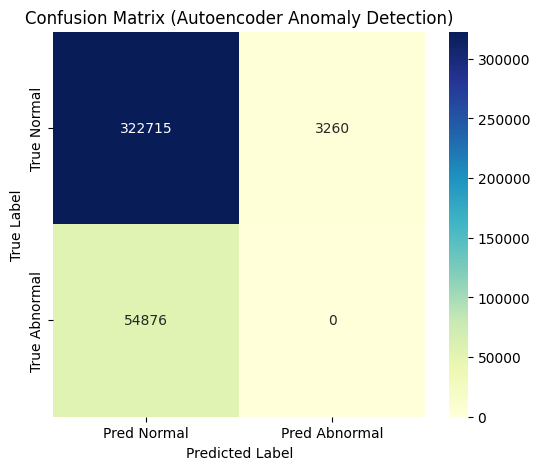

In [ ]:
# -----------------------------
# 13) 성능 평가 지표 출력
# -----------------------------

cm = confusion_matrix(error_df.true_class, y_pred)
print("\nConfusion Matrix:\n", cm)

print("\nClassification Report:\n")
print(classification_report(error_df.true_class, y_pred,
                            target_names=["Normal(Jogging)",
                                          "Abnormal(Sitting)"]))

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu",
            xticklabels=["Pred Normal", "Pred Abnormal"],
            yticklabels=["True Normal", "True Abnormal"])
plt.title("Confusion Matrix (Autoencoder Anomaly Detection)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()